# Input * Gradient Convective Mode
Input * Gradient is an attribution method developed to understand how a deep-learning algorithm interpts input and thus creates predictions (<a href="https://arxiv.org/pdf/1704.02685.pdf">Shrikumar et al. 2019</a>). Gradient is... Input is... Essentially, Input * Gradient demostrates where the model . For example, if input * gradient value is high (in this notebook, red = high value, blue = low value), a change in this region can substainlly change the outputted prediciton. For other resources to explain XAI methods consult <a href="https://journals.ametsoc.org/view/journals/bams/100/11/bams-d-18-0195.1.xml">McGovern et al. 2019</a>, <a href="https://journals.ametsoc.org/view/journals/aies/1/4/AIES-D-22-0012.1.xml#app3">Mamalakis et al. 2022</a>, <a href="https://arxiv.org/pdf/1711.00867.pdf">Kindermans et al. 2017</a>. 

This notebook also uses gradient composite to show effects

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import scipy
import pickle

import tensorflow as tf

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

import cartopy
#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

import scipy as sp
import scipy.ndimage

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker


2023-09-05 14:30:23.272766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Defintions

In [2]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

In [3]:
def smooth_it(Patty):
    sigma_y = 1.5
    sigma_x = 1.5
    sigma = [sigma_y, sigma_x]
    y = sp.ndimage.gaussian_filter(Patty, sigma, mode='constant')
    return y

In [4]:
def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap


def draw_box_plot(ax, img, cbar_shrink=0.35):
    r"""Creates a pre-packaged display for indidivual or summary
    svrimg images.  Modifies an input axis.
    
    Parameters
    ----------
    ax: matplotlib.pyplot.axes.Axes
        Modifiable matplotlib.pyplot axis.
    img: (M, N) ndarray
        SVRIMG radar image
    cbar_shrink: numeric
        Value between 0 - 1.  This will be replacedwith kwargs in 
        future for more customization. Default is 0.35.
    Returns
    -------
    ax: matplotlib.pyplot.axes.Axes
        Modified matplotlib.pyplot axis.
    """ 

    cmap, norm = radar_norm()
    mmp = ax.imshow(np.flipud(img), cmap=cmap, norm=norm)

    
    #plt.colorbar(mmp, ax=ax, shrink=cbar_shrink, pad=0.01)
    
    return ax

def radar_norm():
    r"""Return a colormap and normalization that allow you to represent
    radar data with colors every 5 dBZ that mimics the official NWS
    radar images.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    norm: BoundaryNorm
        Normalization for 5 dBZ levels (0-80).
    """ 

    cmap = radar_colormap()
    classes = np.array(list(range(0, 85, 5)))
    norm = BoundaryNorm(classes, ncolors=cmap.N)    
    
    return cmap, norm

In [5]:
##IG map
cmap_IG = plt.cm.RdGy_r
# extract all colors from the Reds map
cmaplist_IG = [cmap_IG(i) for i in range(cmap_IG.N)]
# make the first color entry to be whhite
cmaplist_IG[0] = cmap_IG(0)
 # make the last color entry to be most extreme--
cmaplist_IG[cmap_IG.N-1] = cmap_IG(0.99)
for ii in range(120,136):
    cmaplist_IG[ii]=[1,1,1,1]
# create the new map
cmap_IG = cmap_IG.from_list('My cmap', cmaplist_IG, cmap_IG.N)
# define the contour levels and normalize
#clevels_IG=(np.arange(-0.0002,0.00022,0.00002))
clevels_IG=(np.arange(-2, 2, 0.05))
norm_IG = mpl.colors.BoundaryNorm(clevels_IG, cmap_IG.N)

In [6]:
##ItG color map 
cmap = plt.cm.RdYlBu_r
# extract all colors from the Reds map
cmaplist = [cmap(i) for i in range(cmap.N)]
# make the first color entry to be whhite
cmaplist[0] = cmap(0)
 # make the last color entry to be most extreme--
cmaplist[cmap.N-1] = cmap(0.99)
for ii in range(115,151):
    cmaplist[ii]=[1,1,1,1]
# create the new map
cmap = cmap.from_list('My cmap', cmaplist, cmap.N)
# define the contour levels and normalize
clevels=(np.arange(-2, 2, 0.05))
norm = mpl.colors.BoundaryNorm(clevels, cmap.N)

## Load Data and Model

In [7]:
#load the training/testing/validation datasets
with open("/share/jcorner_data/pkls/1996_2011_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/2012_2013_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/2014_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


In [8]:
#load the model
model = tf.keras.models.load_model('/share/jcorner_data/models/morph_model_v03.h5')
#model = tf.keras.models.load_model('/share/jcorner_data/models/morph_model_nospace_v04.h5')

2023-09-05 14:30:24.756955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#
mode_pred = model.predict(x_test)
mode_pred = np.argmax(mode_pred,axis=1)

modelcorr = mode_pred==y_test

nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = y_test.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

29/29 [==============================] - 6s 207ms/step
Model accuracy on testing is 87.500000%


In [10]:
#
for classnum in range(np.max(mode_pred)+1):

    #
    locals()[f'class_{classnum}_pred'] = (mode_pred==classnum)

    #
    locals()[f'class_{classnum}_mode'] = x_test[locals()[f'class_{classnum}_pred'],:]
    locals()[f'class_{classnum}_mode'] = np.reshape(locals()[f'class_{classnum}_mode'],(locals()[f'class_{classnum}_mode'].shape[0],136,136))

    #
    locals()[f'class_{classnum}_mode'] = np.mean(locals()[f'class_{classnum}_mode'],axis=0)

## Composites

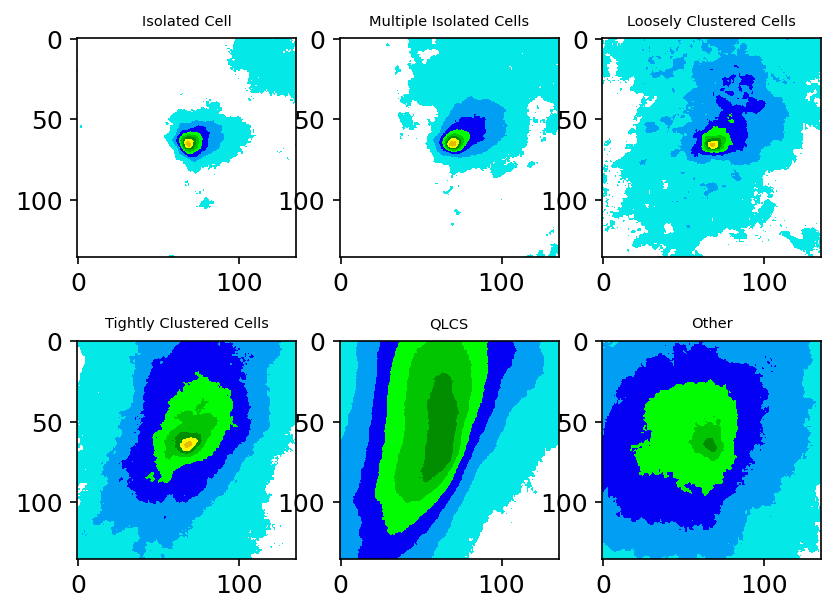

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
%matplotlib inline

#load a radarcolormap
cmap_r = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap_r.N)

modes = ['Isolated Cell', 'Multiple Isolated Cells',
                'Loosely Clustered Cells', 'Tightly Clustered Cells', 
                'QLCS', 'Other']

for classnum in range(np.max(mode_pred)+1):
    
    ax = plt.subplot(2,3,classnum+1)
    sample = locals()[f'class_{classnum}_mode'] *80
    ax.set_title(modes[classnum], fontsize=7)

    draw_box_plot(ax, sample.squeeze())

## Calculate Input * Gradient

In [12]:
#make predictions of testing data
mode_pred = model.predict(x_test)
mode_pred = np.argmax(mode_pred,axis=1)

#find where NN is correct
modelcorr = mode_pred==y_test

mode_true_cor = y_test[modelcorr]
mode_pred_cor = mode_pred[modelcorr]

#iterate through the class number of each mode
for classnum in range(np.max(mode_pred)+1):

    #match the current mode to 
    class_corr = (mode_pred==classnum)

    #
    corrs = modelcorr * class_corr
    refc_class_corr = x_test[corrs]

    ## arrays of ItG maps
    locals()[f'mode_{classnum}_ItG_heatmap'] = np.zeros(shape =(np.shape(refc_class_corr)[0],x_test.shape[-2],x_test.shape[-2]))
    locals()[f'mode_{classnum}_Grad_heatmap'] = np.zeros(shape =(np.shape(refc_class_corr)[0],x_test.shape[-2],x_test.shape[-2]))
    
    #
    for s,sample in enumerate(refc_class_corr):
        locals()[f'mode_{classnum}_Grad_heatmap'][s] = get_gradients((sample.reshape((1,x_test.shape[-2],x_test.shape[-2]))),top_pred_idx=0).numpy()
        locals()[f'mode_{classnum}_ItG_heatmap'][s] = np.multiply(locals()[f'mode_{classnum}_Grad_heatmap'][s],sample.reshape((1,x_test.shape[-2],x_test.shape[-2])))
        
    #
    locals()[f'input_{classnum}_mean'] = np.reshape(np.mean(refc_class_corr,axis=0),(136,136))
    locals()[f'mode_{classnum}_Grad_meanheatmap'] = np.reshape(np.mean(locals()[f'mode_{classnum}_Grad_heatmap'],axis=0),(136,136))
    locals()[f'mode_{classnum}_ItG_meanheatmap'] = np.reshape(np.mean(locals()[f'mode_{classnum}_ItG_heatmap'],axis=0),(136,136))
    
    #standerdize the data
    locals()[f'mode_{classnum}_ItG_meanheatmap_std'] = np.std(locals()[f'mode_{classnum}_ItG_meanheatmap'])
    locals()[f'mode_{classnum}_ItG_meanheatmap_avg'] = np.mean(locals()[f'mode_{classnum}_ItG_meanheatmap'])
    locals()[f'mode_{classnum}_ItG_meanheatmap_stan'] = (locals()[f'mode_{classnum}_ItG_meanheatmap'] - locals()[f'mode_{classnum}_ItG_meanheatmap_avg']) / locals()[f'mode_{classnum}_ItG_meanheatmap_std']
    
    locals()[f'mode_{classnum}_Grad_meanheatmap_std'] = np.std(locals()[f'mode_{classnum}_Grad_meanheatmap'])
    locals()[f'mode_{classnum}_Grad_meanheatmap_avg'] = np.mean(locals()[f'mode_{classnum}_Grad_meanheatmap'])
    locals()[f'mode_{classnum}_Grad_meanheatmap_stan'] = (locals()[f'mode_{classnum}_Grad_meanheatmap'] - locals()[f'mode_{classnum}_Grad_meanheatmap_avg']) / locals()[f'mode_{classnum}_Grad_meanheatmap_std']

29/29 [==============================] - 4s 154ms/step


## Plot Gradient Composite

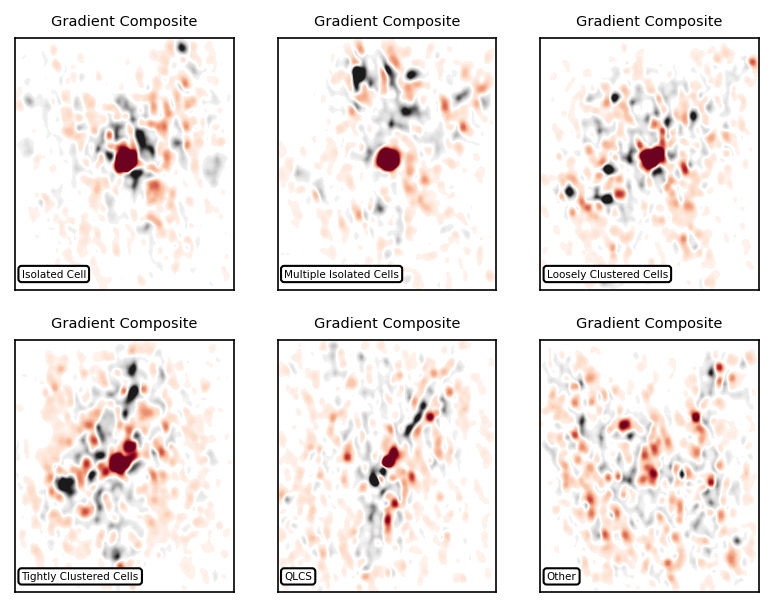

In [15]:
for classnum in range(np.max(mode_pred)+1):

    #
    ax1 = plt.subplot(2,3,classnum+1)
    ax1.contourf(smooth_it(locals()[f'mode_{classnum}_Grad_meanheatmap_stan']), levels=clevels_IG,cmap=cmap_IG,extend='both')

    #
    plt.title(f'Gradient Composite' ,fontsize=7)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    ax1.annotate(f'{modes[classnum]}', (0.03,0.05),fontsize=5, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), xycoords='axes fraction')



## Plot Input * Gradient

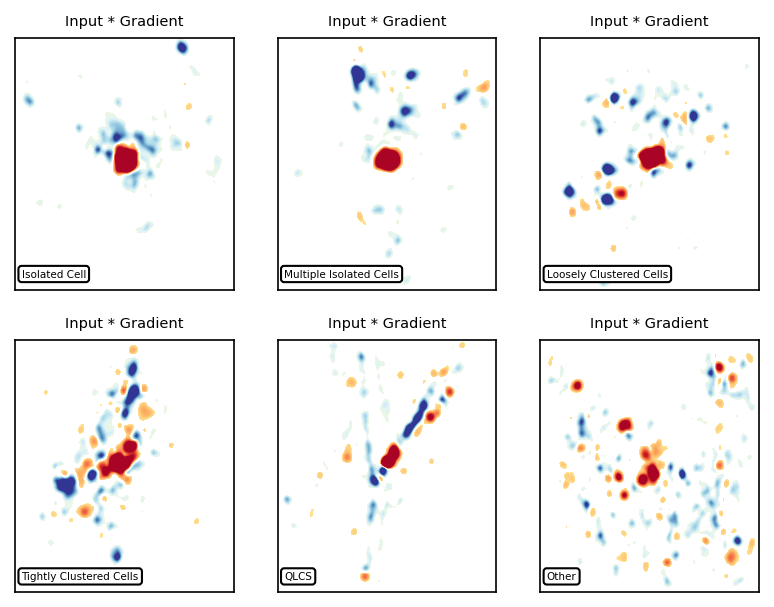

In [14]:
for classnum in range(np.max(mode_pred)+1):

    #
    ax1 = plt.subplot(2,3,classnum+1)
    ax1.contourf(smooth_it(locals()[f'mode_{classnum}_ItG_meanheatmap_stan']), levels=clevels,cmap=cmap,extend='both')

    #
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    plt.title('Input * Gradient' ,fontsize=7)
    ax1.annotate(f'{modes[classnum]}', (0.03,0.05),fontsize=5, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), xycoords='axes fraction')
